# Real data comparison

In [8]:
%matplotlib inline

from __future__ import division

import os
import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.reset_defaults()

from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance

# from regain import model_selection; reload(model_selection)
from regain.covariance import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.utils import error_norm

## Biological data

In [12]:
path = "../regain/data/ecoli"

In [13]:
df = pd.read_excel(os.path.join(path, "inline-supplementary-material-2.xls"), skiprows=1, index_col=0)
best_dims = pd.read_csv(os.path.join(path, "inline-supplementary-material-3.txt"), delimiter="\t",
                            skiprows=[0,2], skipinitialspace=True)

In [14]:
df.columns = df.columns.str.lower()

In [15]:
best_dims['sum_abs_diff_stress'] = (np.abs(best_dims['cold_2'] - best_dims['cold_3']) + 
    np.abs(best_dims['heat_2'] - best_dims['heat_3']) +
    np.abs(best_dims['oxidative_2'] - best_dims['oxidative_3']))

In [16]:
dims = best_dims.sort_values("sum_abs_diff_stress", ascending=False).head(10)['condition_timepoint'].tolist()

In [17]:
for x in ['shikimic acid-3-phosphate', "methionine", '2-ketobutyric acid']:
    try:
        dims.remove(x)
    except:
        pass

In [18]:
df_reduced = df.loc[:,['time point', 'stress'] + dims].fillna(1)

# stresses = ['cold stress', 'heat stress', 'oxidative stress']
stresses = ['heat stress', 'cold stress']
df_reduced = df_reduced[df_reduced.stress.isin(stresses)]

In [19]:
a3d = np.array(list(df.groupby("time point").apply(pd.DataFrame.as_matrix)))

df_group = df_reduced.groupby("time point")
max_timepoints = 12
# df_group = df_group.fillna(0)
min_size = int(np.min([g[dims].values.shape[0] for n, g in df_group if n < max_timepoints]))
X = np.array([group[dims].values[:min_size] for name, group in df_group if name < max_timepoints], dtype=float)
# for name, group in df_group:
#     print group.values.astype(float)

In [20]:
data_list = np.log(X.copy())
data_grid = data_list.transpose(1,2,0)

In [21]:
dims

['isoleucine',
 'phenylalanine',
 'lysine',
 'threonine',
 'asparagine',
 'alanine',
 '2-aminobutyric acid']

In [22]:
names = ['Ile', 'Phe', 'Lys', 'Thr', 'Asn', 'Ala', 'Abu' ]

In [23]:
# # alpha=np.linspace(0.01, 0.2, 5)
# # tau=np.linspace(0.01, 0.8, 5)
# # beta=np.linspace(0.01, 0.8, 2)
# # eta=np.linspace(0.01, 0.8, 2)
# # params = dict(tau=tau, eta=eta, alpha=alpha, beta=beta)

# # ltgl = GridSearchCV(mdl, params, cv=ShuffleSplit(3, test_size=.5), verbose=True).fit(data_grid)

# domain = [
#     #{'name': 'alpha', 'type': 'continuous', 'domain': (-2., 0)},
#      {'name': 'tau', 'type': 'continuous', 'domain': (-2, 0)},
#      {'name': 'beta', 'type': 'continuous', 'domain': (0.,2)},
#      {'name': 'eta', 'type': 'continuous', 'domain': (0,2)},
# ]
# ltgl = model_selection.BayesianOptimization(
#     mdl, domain=domain, n_jobs=2, acquisition_weight=1, acquisition_jitter=.01, verbosity=True,
#     acquisition_type='EI', max_iter=200, cv=ShuffleSplit(3, test_size=.1)).fit(data_grid)

In [24]:
# best_params = ltgl.best_params_.copy()
# alpha = best_params['alpha']
# best_params

In [33]:
ll = latent_time_graph_lasso_.LatentTimeGraphLasso(
    time_on_axis='last', assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5, psi='l2',
    max_iter=600, rho=1./ np.sqrt(np.array(data_list).shape[1]))

In [127]:
# # with the top 7
# ll.set_params(eta=.5, beta=.5, alpha=.3, tau=.5, psi='laplacian',
#               phi='l2', rho=1. / np.sqrt(data_grid.shape[0]),
#              update_rho_options=dict(mu=5), max_iter=500).fit(
#     data_grid[:,:,:9])
reload(latent_time_graph_lasso_)
emp_cov = np.array([empirical_covariance(x) for x in data_list[:9]])
res = latent_time_graph_lasso_.latent_time_graph_lasso(
    emp_cov, eta=.2, beta=.8, alpha=.3, tau=.5, psi='laplacian',
    phi='l2', rho=1. / np.sqrt(data_grid.shape[0]), rtol=1e-05, tol=1e-05,
             update_rho_options=dict(mu=5), max_iter=500)

ll.precision_ = res[0]
ll.latent_ = res[1]
# # with the top 20
# ll.set_params(eta=.5, beta=.6, alpha=.5, tau=.5, psi='laplacian',
#               phi='l2', rho=1. / np.sqrt(data_grid.shape[0]),
#              update_rho_options=dict(mu=5), max_iter=500).fit(
#     data_grid[:,:,:9])

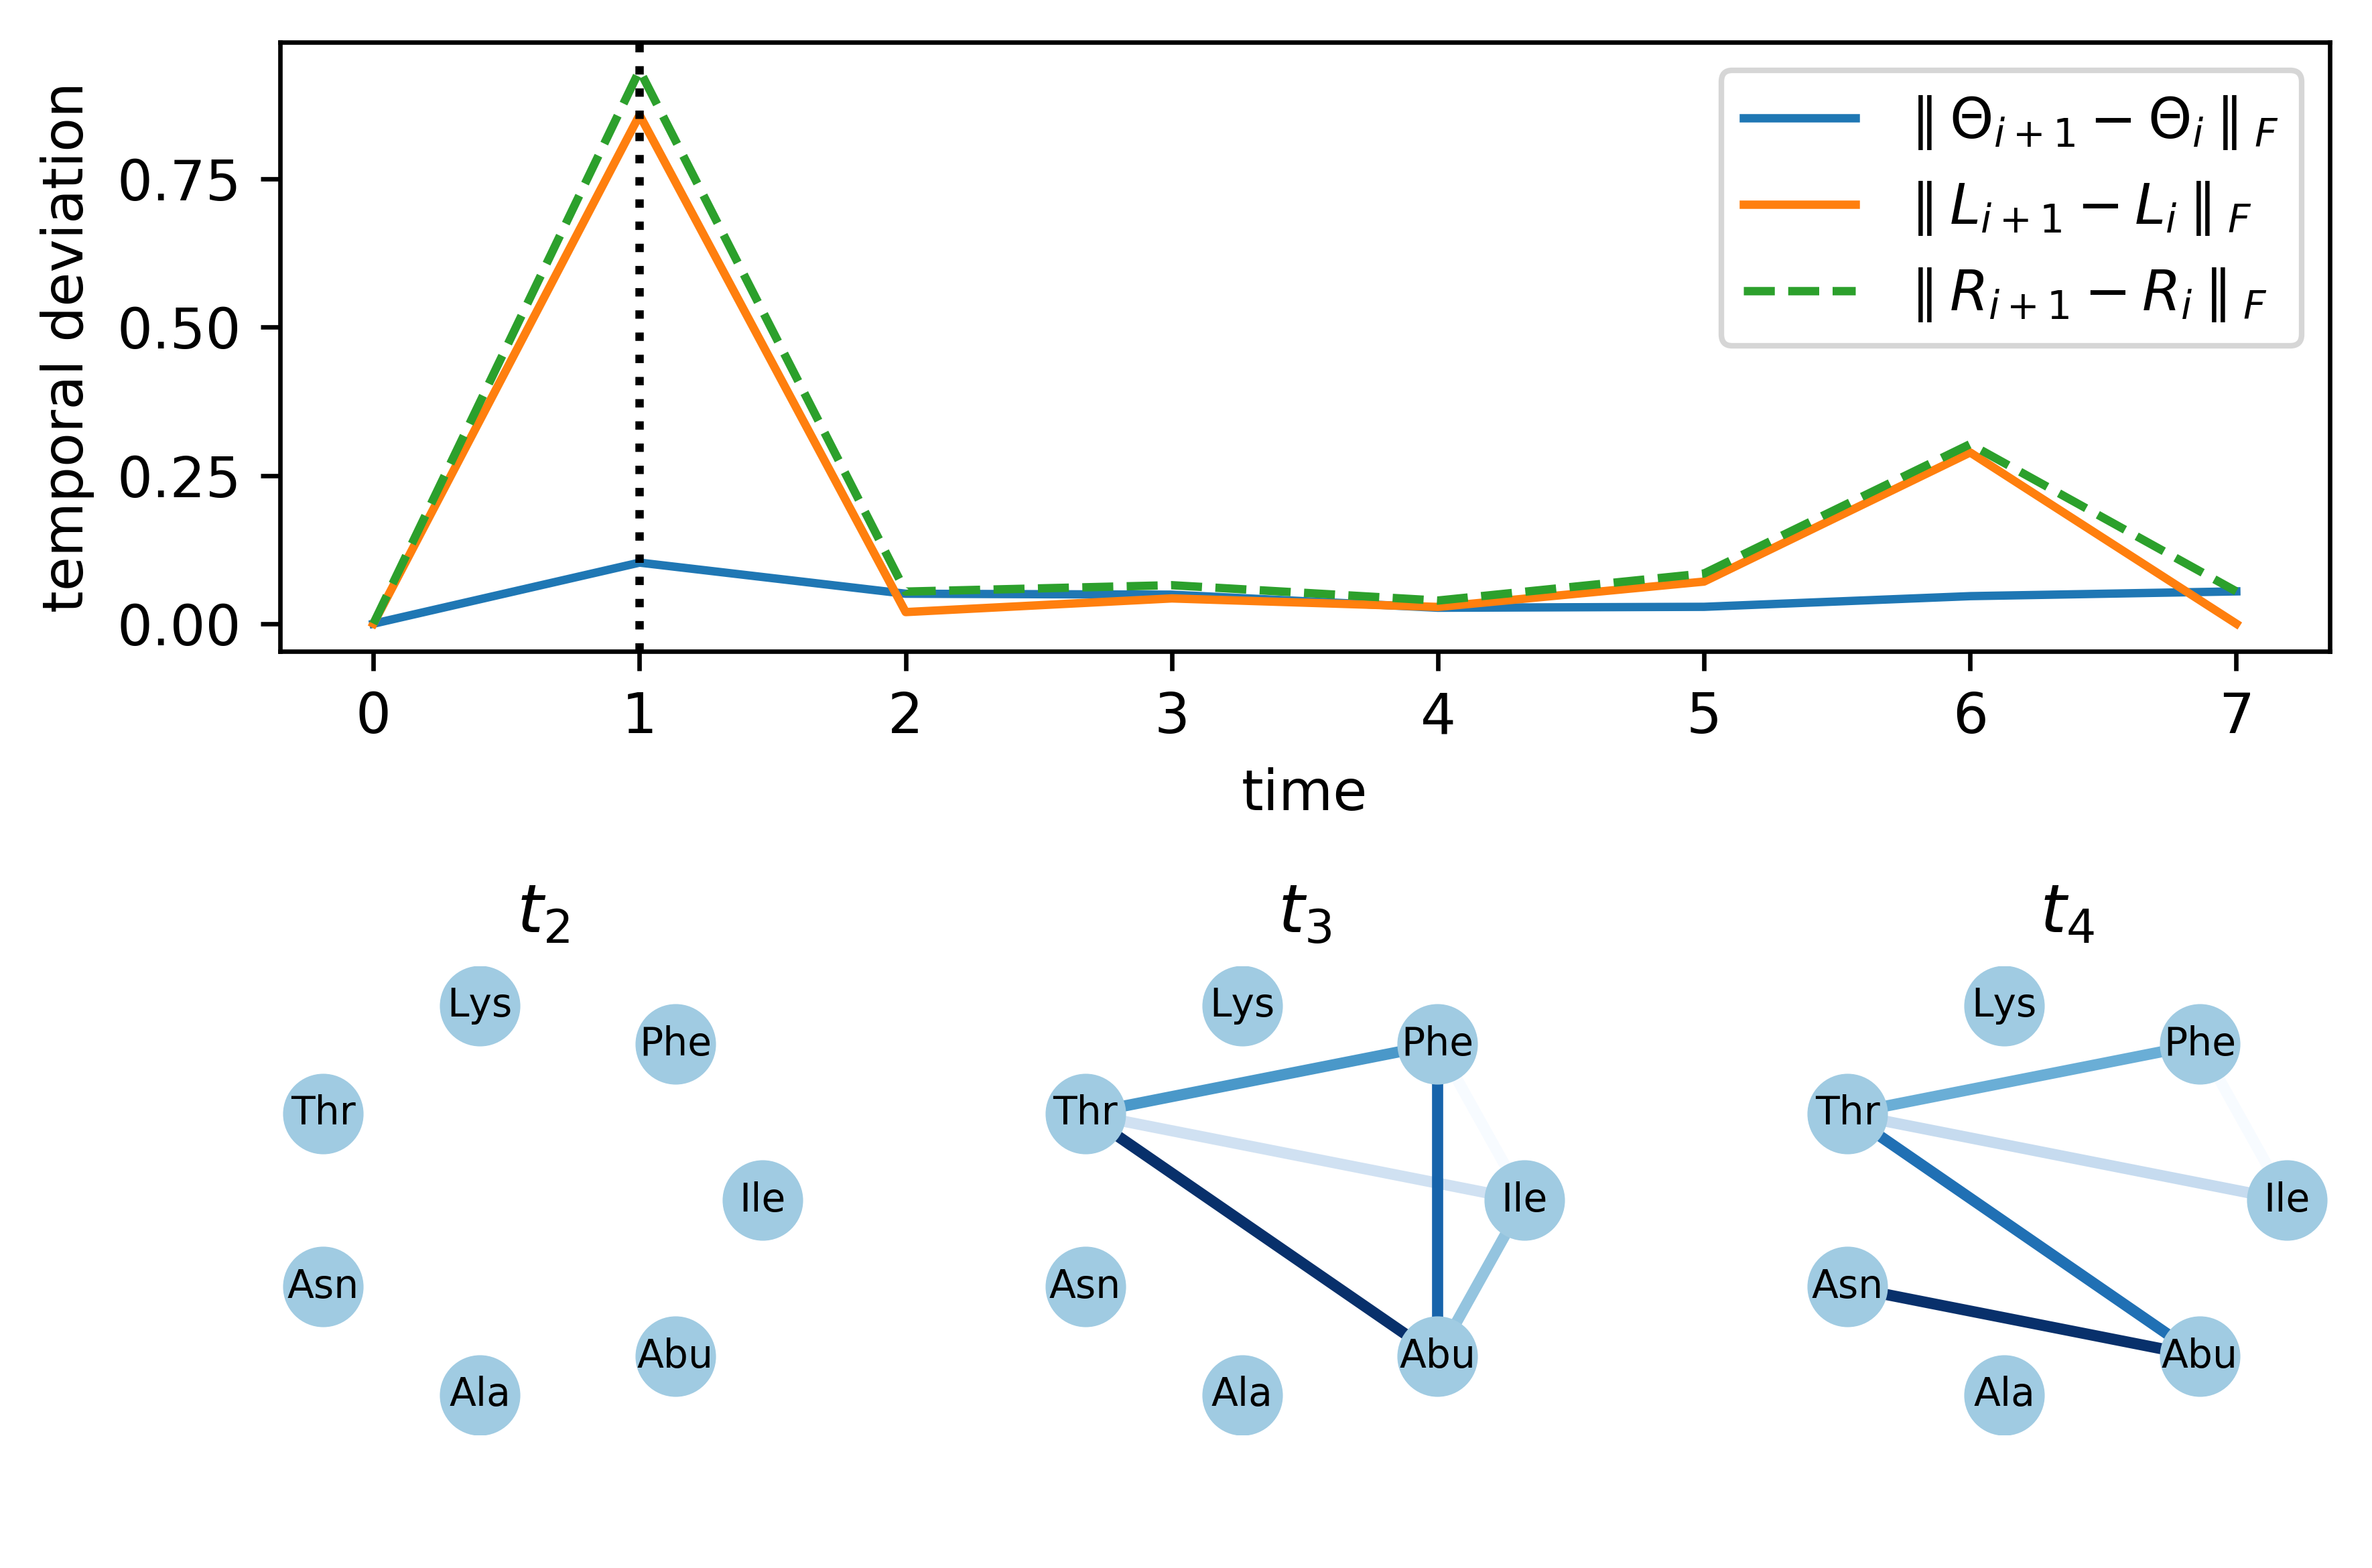

In [128]:
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 3, height_ratios=[1.3, 1]) 

f = plt.figure(figsize=(6,4), dpi=600)
ax = f.add_subplot(gs[0,:]) 
prec = np.array([p - np.diag(np.diag(p)) for p in ll.precision_])
late = ll.latent_

precision_data = [np.linalg.norm(prec[i+1] - prec[i]) for i in range(prec.shape[0]-1)]
latent_data = [np.linalg.norm(late[i+1] - late[i]) for i in range(late.shape[0]-1)]
r_data = [np.linalg.norm((prec[i+1]- late[i+1]) - (prec[i] - late[i]) ) for i in range(late.shape[0]-1)]
timepoints = [r'$t_{%d - %d}$'%(i,i+1) for i in range(1, prec.shape[0])]

s1 = ax.plot(precision_data, label=r'$\parallel \Theta_{i+1} - \Theta_i\parallel_F$')
# ax.tick_params('y', colors='C0')
ax2 = ax#.twinx()
s2 = ax2.plot(latent_data, label=r'$\parallel L_{i+1} - L_i\parallel_F$', c='C1')
s3 = ax2.plot(r_data, label=r'$\parallel R_{i+1} - R_i\parallel_F$', ls='--', c='C2')
ax2#.tick_params('y', colors='C1')

ax.axvline(1, ls=':', c='k')
ax.set_ylabel("temporal deviation");

ax.set_xlabel("time");
ax.set_xticks(np.arange(prec.shape[0]-1), timepoints)
ax.legend(s1+s2+s3,
           [r'$\parallel \Theta_{i+1} - \Theta_i\parallel_F$', r'$\parallel L_{i+1} - L_i\parallel_F$',
           r'$\parallel R_{i+1} - R_i\parallel_F$'],
           loc='upper right')

# ax.text(-1.5, 0.5, "(a)")
# ax.text(-1.5, -0.4, "(b)")

from functools import partial
from regain import plot; reload(plot)
plot_func = partial(
    plot.plot_graph_with_latent_variables, labels=dict(zip(range(len(dims)), names)),
    node_size=180, font_size=7)

ax = f.add_subplot(gs[1,0])
plot_func(prec[1], len(dims), title=r'$t_%d$' % (2), ax=ax)

ax = f.add_subplot(gs[1,1])
plot_func(prec[2], len(dims), title=r'$t_%d$' % (3), ax=ax)

ax = f.add_subplot(gs[1,2])
plot_func(prec[3], len(dims), title=r'$t_%d$' % (4), ax=ax)

plt.tight_layout()
plt.show()

In [129]:
f.savefig("real_data_temporal_deviation_bio_grid_ab.pdf", dpi=600, transparent=True, bbox_inches='tight')

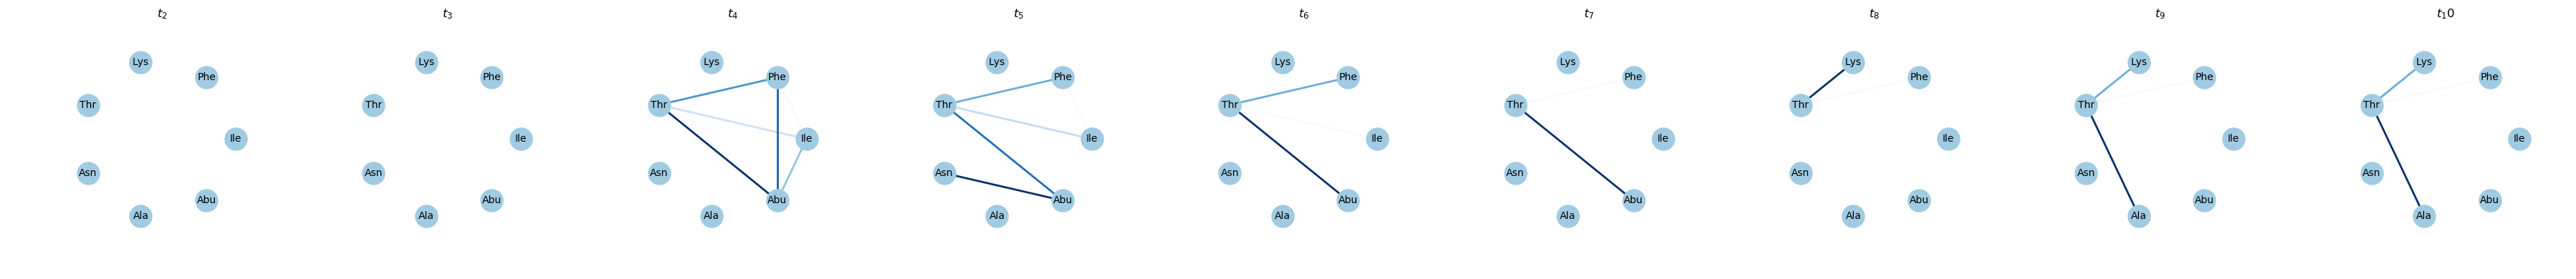

In [130]:
from regain import plot; reload(plot)
f, ax = plt.subplots(1, len(precisions), figsize=(len(precisions) * 4, 4))

for i, p in enumerate(precisions):
#     p[np.abs(p) < 1e-1] = 0
    plot.plot_graph_with_latent_variables(
        p, len(dims), labels=dict(zip(range(len(dims)), names)),
        title=r'$t_%d$' % (i + 1 + start_index), ax=ax[i], node_size=500, font_size=10)

f.tight_layout()
plt.show()

In [136]:
f.savefig("real_data_temporal_deviation_bio_networks_three.pdf", dpi=600, transparent=True, bbox_inches='tight')

# Finance data
Here we show an example of using LTGL for finance data. Data can be downloaded at http://quantquote.com/files/quantquote_daily_sp500_83986.zip

Once the file is downloaded, move it to this directory and unzip it. Unzip the file by clicking on it (in Windows), or by executing this command from the command line:

```bash
unzip quantquote_daily_sp500_83986.zip
```

In [8]:
def cross_validate(data_grid, model='bo', **kwargs):
    def scoring_func(estimator, Xts, yts=None):
        true = kwargs.get('K')
        return utils.structure_error(true, estimator.precision_)['f1']
    
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        eta=1, beta=1, alpha=kwargs.get('alpha', .8), tau=kwargs.get('tau', .2),psi='node', phi='l2',
        time_on_axis='last', assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5, compute_objective=False,
        max_iter=250, rho=1./ np.sqrt(data_grid.shape[0]))
    cv = ShuffleSplit(3, test_size=0.1)
    if model == 'gs':
        ltgl = GridSearchCV(mdl, kwargs['param_grid'], cv=cv, verbose=3, scoring=scoring_func)
    else:
        domain = [
            {'name': 'tau', 'type': 'continuous', 'domain': (-2, 0)},
            {'name': 'alpha', 'type': 'continuous', 'domain': (-2., 0)},
            {'name': 'beta', 'type': 'continuous', 'domain': (-3.,np.log10(.5))},
            {'name': 'eta', 'type': 'continuous', 'domain': (-3.,np.log10(.5))},
        ]
        ltgl = model_selection.BayesianOptimization(
            mdl, domain=domain, n_jobs=1, acquisition_weight=1, acquisition_jitter=.01,
            acquisition_type='EI', max_iter=50, cv=cv, verbosity=True, verbose=1)

    ltgl.fit(data_grid)
    return ltgl.best_params_

In [141]:
def read_financial(filename):
    df = pd.read_csv(filename, header=None, index_col=0, usecols=[0,2,3,4, 5])
    df.columns = range(4)
    df_stack = df.stack()
    df_stack.name = filename.split("/")[-1].split('_')[1].split('.')[0].upper()
    return df_stack
    
def read_all_financial(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory)]
    dfs = []
    for f in files:
        dfs.append(read_financial(f))
    return pd.concat(dfs, axis=1)

def filter_dataframe(df, companies=None, start_year=None, end_year=None, drop_na=True, log_scale=True):
    if companies is not None:
        df = df[companies]
    
    if drop_na:
        df = df.dropna()
        
    if log_scale:
        df = np.log(df)
    
    if start_year is not None:
        start_idx = [i for i, x in enumerate(df.index.get_level_values(0))
                     if str(x).startswith(str(start_year))][0]
    else:
        start_idx = 0
    if end_year is not None:
        end_idx = [i for i, x in enumerate(df.index.get_level_values(0))
                   if str(x).startswith(str(end_year))][-1] + 1
    else:
        end_idx = -1
        
    return df.iloc[start_idx:end_idx]

def filter_dataframe_months(df, companies=None, start_year=None, end_year=None, start_month=None, 
                            end_month=None, drop_na=True, log_scale=True):
    if companies is not None:
        df = df[companies]
    
    if drop_na:
        df = df.dropna()
        
    if log_scale:
        df = np.log(df)
    
    if start_year is None:
        start_idx=0
    elif start_month is None:
        start_idx = [i for i, x in enumerate(df.index.get_level_values(0))
                     if str(x).startswith(str(start_year))][0]
    else:
        start_idx = [i for i, x in enumerate(df.index.get_level_values(0))
                     if str(x).startswith(str(start_year)+str(start_month))][0]
    
    if end_year is None:
        end_idx=-1
    elif end_month is None:
        end_idx = [i for i, x in enumerate(df.index.get_level_values(0))
                   if str(x).startswith(str(end_year))][-1] + 1
    else:
        end_idx = [i for i, x in enumerate(df.index.get_level_values(0))
                   if str(x).startswith(str(end_year)+str(end_month))][-1] + 1
        
    return df.iloc[start_idx:end_idx]

def convert_df_to_data(df, T=20):
    n = int(df.shape[0] / T)
    data = [df.iloc[i*n:(i+1)*n].values for i in range(T)]
    timepoints = ['-'.join(df.iloc[i*n:(i+1)*n].index.levels[0][
        df.iloc[i*n:(i+1)*n].index.labels[0]][[0, -1]].astype(str)) for i in range(T)]
    data = np.array(data)
    return data, timepoints

In [142]:
# df = pd.read_csv("../regain/data/finance/finance.csv", header=0, index_col=0)
df = read_all_financial('/home/fede/Downloads/quantquote_daily_sp500_83986/daily/')

In [144]:
# setting 1 (global)
companies = sorted(['AMZN', 'GOOG', 'MSFT', 'YHOO', 'IBM', 'AAPL', 'INTC', 'NVDA', 'FDX'])
df_filter = filter_dataframe(df, companies=companies, start_year=2007, end_year=2009)
data, timepoints = convert_df_to_data(df_filter, T=36)

# setting 2 (local)
# companies = sorted(['AMZN', 'GOOG', 'MSFT', 'IBM', 'AAPL', 'INTC', 'NVDA', 'DELL'])
# df_filter = filter_dataframe_months(df, companies=companies, start_year=2006, end_year=2006, 
#                                     start_month='06', end_month='09')
# data, timepoints = convert_df_to_data(df_filter, T=17)

In [261]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain import norm; reload(norm)
from regain.covariance import time_graph_lasso_; reload(time_graph_lasso_)
from regain.covariance import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);

# setting 1 (global)
emp_cov = np.array([empirical_covariance(x) for x in data])
ll = latent_time_graph_lasso_.latent_time_graph_lasso(
    emp_cov,
    alpha=0.003, tau=.0002, beta=0.06, eta=0.0095, psi='laplacian', phi='l2',
    rtol=1e-5, tol=1e-5, compute_objective=False,
    max_iter=800, rho=1. / np.sqrt(data.shape[1]), update_rho_options=dict(mu=5))#.fit(data)

# setting 2 (local)
# ll = latent_time_graph_lasso_.LatentTimeGraphLasso(
#     alpha=0.001, tau=.0002, beta=0.01, eta=0.5, psi='node', phi='laplacian',
#     bypass_transpose=True, assume_centered=0, verbose=1, rtol=1e-5, tol=1e-5, compute_objective=False,
#     max_iter=800, rho=1. / np.sqrt(data.shape[1]), update_rho_options=dict(mu=5)).fit(data)

In [262]:
# prec = np.array([p - np.diag(np.diag(p)) for p in ll.precision_])
# late = ll.latent_
prec = np.array([p - np.diag(np.diag(p)) for p in ll[0]])
late = ll[1]

In [263]:
t_variation = [np.linalg.norm(prec[i+1] - prec[i]) for i in range(prec.shape[0]-1)]
l_variation = [np.linalg.norm(late[i+1] - late[i]) for i in range(late.shape[0]-1)]

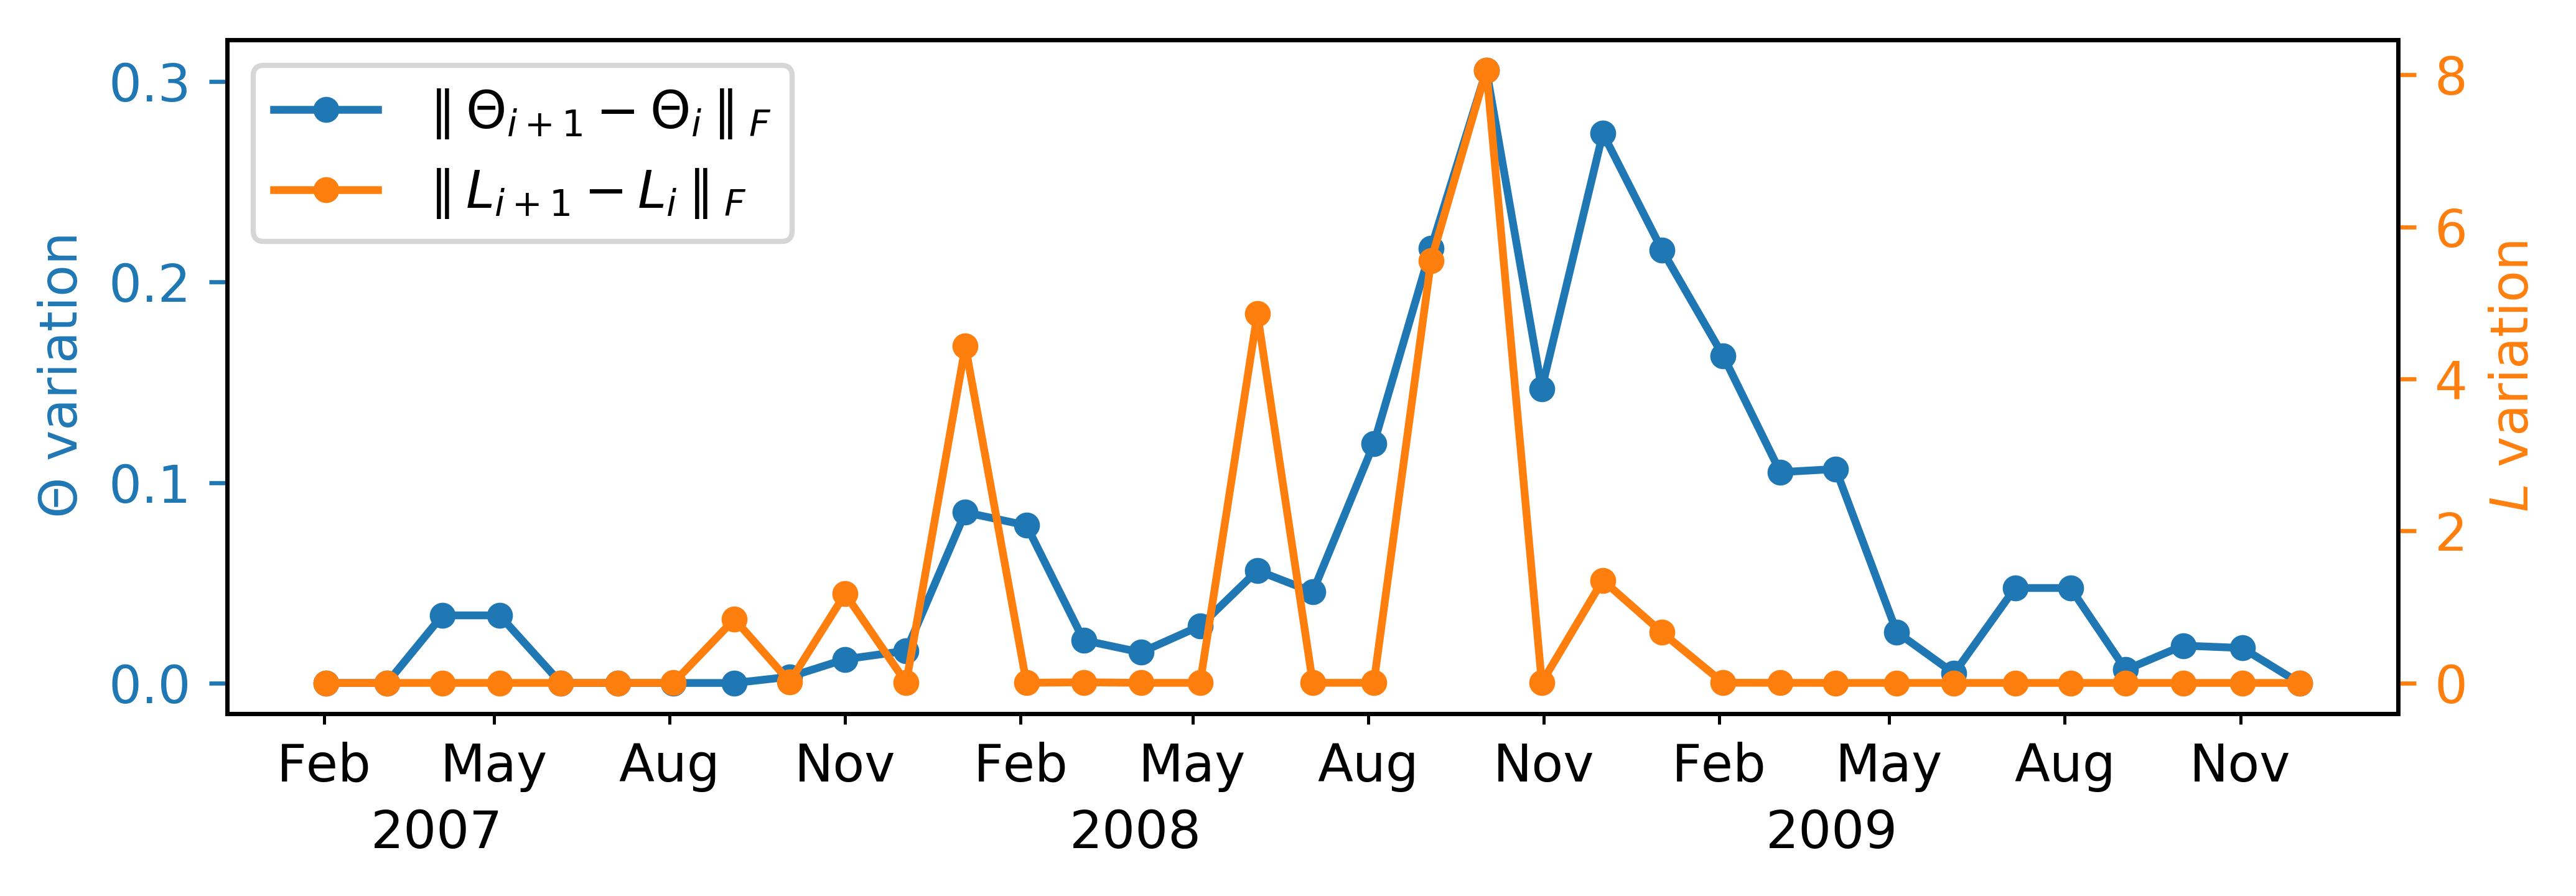

In [264]:
# ax = plt.figure(figsize=(7,4), dpi=300).add_subplot(111)
f = plt.figure(figsize=(7,2.5), dpi=600)
ax = f.add_subplot(111)

dateindex = [pd.Timestamp(x.split('-')[0]) for x in timepoints]
idx = pd.DatetimeIndex(dateindex)[1:]

t_series = pd.Series(data=t_variation, index=idx)
subplot_1 = t_series.plot(ax=ax, style='o-', ms=4,
                          label=r'$\|\|\Theta_{i+1} - \Theta_i\|\|_F$', c='C0')
ax.set_ylabel(r'$\Theta$ variation',color='C0')
ax.tick_params('y', colors='C0')


ax2 = ax.twinx()

l_series = pd.Series(data=l_variation, index=idx)
subplot_2 = l_series.plot(ax=ax2, style='o-', ms=4,
                          label=r'$\|\|L_{i+1} - L_i\|\|_F$', c='C1')
ax2.set_ylabel(r'$L$ variation', color='C1')
ax2.tick_params('y', colors='C1')

# using MatPlotLib date time locators and formatters doesn't work with new pandas datetime index
# ax.xaxis.set_minor_locator(matplotlib.dates.WeekdayLocator(byweekday=(1)))
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=3))
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
ax.xaxis.grid(False, which="major")

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(1, month=4))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('\n%Y'))
ax.xaxis.set_tick_params(rotation=0)  # this requires Matplotlib v2.1 or higher

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

plt.legend([subplot_1.get_legend_handles_labels()[0][0],
           subplot_2.get_legend_handles_labels()[0][0]],
           [r'$\parallel \Theta_{i+1} - \Theta_i\parallel_F$',
            r'$\parallel L_{i+1} - L_i\parallel_F$'],
           loc='upper left')
plt.tight_layout()
plt.show()

In [274]:
f.savefig("global_shift_financial_crisis.pdf", dpi=600, transparent=True, bbox_inches='tight')

In [113]:
# utils.save_pickle(ll.precision_, "global_shift_financial_crisis_thetas.pkl")
# utils.save_pickle(ll.latent_, "global_shift_financial_crisis_latents.pkl")